In [1]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
import transformers
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler,TensorDataset
# from datasets import Dataset
from torch.utils.data import Dataset 
import torch
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm.auto import tqdm
import evaluate
from torch.nn import CrossEntropyLoss
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import os
import glob
import torch
import matplotlib.pyplot as plt
import numpy as np

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:
df = pd.read_csv("data/100pernewscategory.csv")
df.head()

,link,headline,category,short_description,authors,date,PESTEL_label
0,https://www.huffingtonpost.com/entry/mortgage-...,Mortgage Deal Reached In 2008 Shows Pitfalls T...,BUSINESS,"The Obama administration, which is pushing sta...",Loren Berlin,2012-02-05,Economic
1,https://www.huffingtonpost.com/entry/women-in-...,"Women in Business: Kate O'Brien Minson, Presid...",BUSINESS,Kate has lived and breathed the therapeutic ap...,"Laura Dunn, ContributorSocial Media and Commun...",2015-04-25,Economic
2,https://www.huffingtonpost.com/entry/like-athl...,"Like Athletes, Business Owners Need to Learn F...",BUSINESS,"Business owners and top executives can also ""w...","Mary Ellen Biery, ContributorResearch Speciali...",2015-01-19,Economic
3,https://www.huffingtonpost.com/entry/donald-tr...,Trump Could Trigger The Longest Recession Sinc...,BUSINESS,Yikes.,Ben Walsh,2016-06-27,Economic
4,https://www.huffingtonpost.com/entry/grocery-c...,Grocery Chains Made A Promise To The First Lad...,BUSINESS,An AP investigation found that major grocers o...,"Mike Schneider, AP",2015-12-07,Economic


In [3]:
df["content"] = df["headline"] + " " + df["short_description"]
df = df[['PESTEL_label', 'content']]
df.head()

,PESTEL_label,content
0,Economic,Mortgage Deal Reached In 2008 Shows Pitfalls T...
1,Economic,"Women in Business: Kate O'Brien Minson, Presid..."
2,Economic,"Like Athletes, Business Owners Need to Learn F..."
3,Economic,Trump Could Trigger The Longest Recession Sinc...
4,Economic,Grocery Chains Made A Promise To The First Lad...


In [4]:
# convert content to string and handle NaN
df['content'] = df['content'].apply(lambda x: '' if pd.isna(x) else str(x))

In [5]:
def clean_text(text):
    text = text.replace('\n', ' ').strip()
    return text

df['content'] = df['content'].apply(clean_text)

In [6]:
# test set 20%
train_val_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df['PESTEL_label'], random_state=42
)

# train set 70%, val set 10%
train_df, val_df = train_test_split(
    train_val_df, test_size=0.125, stratify=train_val_df['PESTEL_label'], random_state=42
)

In [7]:
class NewsDataset(Dataset):
    def __init__(self, data, tokenizer, max_len, pestel_to_idx):
        self.df = data
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.pestel_to_idx = pestel_to_idx

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index] 
        content = row['content']
        label = row['PESTEL_label']

        inputs = self.tokenizer.encode_plus(
            content,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )

        return {
            'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'targets': torch.tensor(self.pestel_to_idx[label], dtype=torch.long)
        }
        
pestel_to_idx = {
    "Political": 0,
    "Economic": 1,
    "Social": 2,
    "Technological": 3,
    "Environmental": 4,
    "Legal": 5
}

In [8]:
class_names = ["Political", "Economic", "Social", "Technological", "Environmental", "Legal"]

In [9]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:
distilbert_model = transformers.DistilBertModel.from_pretrained('distilbert-base-uncased')

In [11]:
class PestelClassifier(torch.nn.Module):
    def __init__(self, distilbert, num_classes):
        super(PestelClassifier, self).__init__()
        self.distilbert = distilbert
        self.dropout = torch.nn.Dropout(0.3)
        self.output = torch.nn.Linear(768, num_classes)
        
        # self.classifier = torch.nn.Sequential(
        #     torch.nn.Linear(768, 256),
        #     torch.nn.ReLU(),
        #     torch.nn.Dropout(0.5),
        #     torch.nn.Linear(256, num_classes)
        # )

    def forward(self, ids, mask):
        output = self.distilbert(ids, attention_mask=mask)
        output = self.dropout(output[0][:, 0, :])  # CLS token
        output = self.output(output)
        return output
    
        # output = self.distilbert(ids, attention_mask=mask).last_hidden_state[:, 0, :]
        # output = self.classifier(output)
        # return output

In [12]:
def train_bert_model(model, train_loader, val_loader, device, epochs, optimizer, loss_function, patience=3, checkpoint_dir=None, resume=False):
    start_epoch = 0
    best_val_loss = float('inf')
    patience_counter = 0

    if checkpoint_dir and not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    # track history
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_f1': [], 'val_f1': [],
        'train_precision': [], 'val_precision': [],
        'train_recall': [], 'val_recall': []
    }

    # resume from latest checkpoint if specified
    if resume and checkpoint_dir:
        latest_ckpt = find_latest_checkpoint(checkpoint_dir)
        if latest_ckpt:
            print(f"Resuming from checkpoint: {latest_ckpt}")
            model, optimizer, start_epoch = load_checkpoint(model, optimizer, latest_ckpt, device)
            start_epoch += 1

    # train
    for epoch in range(start_epoch, epochs):
        model.train()
        train_loss = 0
        train_preds, train_labels = [], []

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} - Training")
        for batch in train_bar:
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            targets = batch['targets'].to(device)

            optimizer.zero_grad()
            outputs = model(ids, mask)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_preds.extend(predicted.cpu().tolist())
            train_labels.extend(targets.cpu().tolist())

            train_bar.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader)
        train_acc = accuracy_score(train_labels, train_preds)
        train_precision = precision_score(train_labels, train_preds, average='macro', zero_division=0)
        train_recall = recall_score(train_labels, train_preds, average='macro', zero_division=0)
        train_f1 = f1_score(train_labels, train_preds, average='macro', zero_division=0)

        # validation
        model.eval()
        val_loss = 0
        val_preds, val_labels = [], []

        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1} - Validation")
        with torch.no_grad():
            for batch in val_bar:
                ids = batch['ids'].to(device)
                mask = batch['mask'].to(device)
                targets = batch['targets'].to(device)

                outputs = model(ids, mask)
                loss = loss_function(outputs, targets)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_preds.extend(predicted.cpu().tolist())
                val_labels.extend(targets.cpu().tolist())

                val_bar.set_postfix(loss=loss.item())

        avg_val_loss = val_loss / len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds)
        val_precision = precision_score(val_labels, val_preds, average='macro', zero_division=0)
        val_recall = recall_score(val_labels, val_preds, average='macro', zero_division=0)
        val_f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)

        # store metrics for graph plotting
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_precision'].append(train_precision)
        history['val_precision'].append(val_precision)
        history['train_recall'].append(train_recall)
        history['val_recall'].append(val_recall)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)

        print(f"Epoch {epoch+1}")
        print(f"\tTrain Loss: {avg_train_loss:.4f} | Acc: {train_acc*100:.2f}% | P: {train_precision:.4f} | R: {train_recall:.4f} | F1: {train_f1:.4f}")
        print(f"\tVal   Loss: {avg_val_loss:.4f} | Acc: {val_acc*100:.2f}% | P: {val_precision:.4f} | R: {val_recall:.4f} | F1: {val_f1:.4f}")

        # save best model + early stopping
        if checkpoint_dir and avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_path = os.path.join(checkpoint_dir, "best_model.pt")
            save_checkpoint(model, optimizer, epoch, best_path)
            print(f"Best model saved to {best_path}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

        # save checkpoint every 20 epochs
        if checkpoint_dir and (epoch + 1) % 20 == 0:
            path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pt")
            save_checkpoint(model, optimizer, epoch, path)
            print(f"Checkpoint saved to {path}")

    # for last validation
    print("\nFinal Validation Classification Report:")
    print(classification_report(val_labels, val_preds, digits=4))

    return history


In [13]:
import matplotlib.pyplot as plt

def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    def plot_metric(metric_name, ylabel):
        plt.figure()
        plt.plot(epochs, history[f'train_{metric_name}'], label='Train')
        plt.plot(epochs, history[f'val_{metric_name}'], label='Validation')
        plt.title(f'{ylabel} over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel(ylabel)
        plt.legend()
        plt.grid(True)
        plt.show()

    plot_metric('loss', 'Loss')
    plot_metric('acc', 'Accuracy')
    # plot_metric('precision', 'Precision')
    # plot_metric('recall', 'Recall')
    # plot_metric('f1', 'F1 Score')

In [14]:
def evaluate_bert_model(model, data_loader, loss_function, device, set_name="Test"):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    loop = tqdm(data_loader, desc=f"{set_name} Evaluation")

    with torch.no_grad():
        for batch in loop:
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            targets = batch['targets'].to(device)

            outputs = model(ids, mask)
            loss = loss_function(outputs, targets)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().tolist())
            all_targets.extend(targets.cpu().tolist())

            loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)

    print(f"{set_name} Loss: {avg_loss:.4f} | Acc: {accuracy*100:.2f}% | P: {precision:.4f} | R: {recall:.4f} | F1: {f1:.4f}")

    return avg_loss, accuracy, precision, recall, f1, all_preds, all_targets

In [15]:
def save_checkpoint(model, optimizer, epoch, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, path)

def load_checkpoint(model, optimizer, path, device):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return model, optimizer, checkpoint['epoch']

def find_latest_checkpoint(checkpoint_dir):
    checkpoints = glob.glob(os.path.join(checkpoint_dir, 'checkpoint_epoch_*.pt'))
    if not checkpoints:
        return None
    return max(checkpoints, key=os.path.getctime)

In [16]:
num_classes = 6  # For PESTEL
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PestelClassifier(distilbert_model, num_classes)
model.to(device)

PestelClassifier(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): 

In [17]:
EPOCHS = 400
LEARNING_RATE = 1e-6
MAX_LEN = 128
BATCH_SIZE = 32 

train_set = NewsDataset(train_df, tokenizer, MAX_LEN, pestel_to_idx)
val_set = NewsDataset(val_df, tokenizer, MAX_LEN, pestel_to_idx)
test_set = NewsDataset(test_df, tokenizer, MAX_LEN, pestel_to_idx)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
loss_function = torch.nn.CrossEntropyLoss()

Resuming from checkpoint: ./checkpoints_100per/checkpoint_epoch_120.pt


Epoch 121 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.36it/s, loss=0.754]


Epoch 121
	Train Loss: 0.3960 | Acc: 91.43% | P: 0.9148 | R: 0.9143 | F1: 0.9133
	Val   Loss: 0.8830 | Acc: 71.67% | P: 0.7259 | R: 0.7167 | F1: 0.7167
Best model saved to ./checkpoints_100per/best_model.pt


Epoch 122 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.40it/s, loss=0.755]


Epoch 122
	Train Loss: 0.3920 | Acc: 92.14% | P: 0.9211 | R: 0.9214 | F1: 0.9207
	Val   Loss: 0.8840 | Acc: 71.67% | P: 0.7259 | R: 0.7167 | F1: 0.7167


Epoch 123 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.37it/s, loss=0.749]


Epoch 123
	Train Loss: 0.4074 | Acc: 91.19% | P: 0.9122 | R: 0.9119 | F1: 0.9112
	Val   Loss: 0.8794 | Acc: 71.67% | P: 0.7259 | R: 0.7167 | F1: 0.7167
Best model saved to ./checkpoints_100per/best_model.pt


Epoch 124 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.40it/s, loss=0.743]


Epoch 124
	Train Loss: 0.3868 | Acc: 91.67% | P: 0.9169 | R: 0.9167 | F1: 0.9160
	Val   Loss: 0.8752 | Acc: 71.67% | P: 0.7259 | R: 0.7167 | F1: 0.7167
Best model saved to ./checkpoints_100per/best_model.pt


Epoch 125 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.39it/s, loss=0.742]


Epoch 125
	Train Loss: 0.3624 | Acc: 92.86% | P: 0.9285 | R: 0.9286 | F1: 0.9279
	Val   Loss: 0.8735 | Acc: 71.67% | P: 0.7259 | R: 0.7167 | F1: 0.7167
Best model saved to ./checkpoints_100per/best_model.pt


Epoch 126 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.38it/s, loss=0.741]


Epoch 126
	Train Loss: 0.3525 | Acc: 92.62% | P: 0.9268 | R: 0.9262 | F1: 0.9257
	Val   Loss: 0.8730 | Acc: 70.00% | P: 0.7018 | R: 0.7000 | F1: 0.6975
Best model saved to ./checkpoints_100per/best_model.pt


Epoch 127 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.38it/s, loss=0.741]


Epoch 127
	Train Loss: 0.3476 | Acc: 93.10% | P: 0.9313 | R: 0.9310 | F1: 0.9305
	Val   Loss: 0.8725 | Acc: 70.00% | P: 0.7018 | R: 0.7000 | F1: 0.6975
Best model saved to ./checkpoints_100per/best_model.pt


Epoch 128 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.37it/s, loss=0.742]


Epoch 128
	Train Loss: 0.3527 | Acc: 93.10% | P: 0.9314 | R: 0.9310 | F1: 0.9303
	Val   Loss: 0.8726 | Acc: 70.00% | P: 0.7018 | R: 0.7000 | F1: 0.6975


Epoch 129 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.35it/s, loss=0.744]


Epoch 129
	Train Loss: 0.3395 | Acc: 93.33% | P: 0.9338 | R: 0.9333 | F1: 0.9327
	Val   Loss: 0.8739 | Acc: 70.00% | P: 0.7018 | R: 0.7000 | F1: 0.6975


Epoch 130 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.38it/s, loss=0.744]


Epoch 130
	Train Loss: 0.3546 | Acc: 93.81% | P: 0.9384 | R: 0.9381 | F1: 0.9378
	Val   Loss: 0.8743 | Acc: 70.00% | P: 0.7018 | R: 0.7000 | F1: 0.6975


Epoch 131 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.39it/s, loss=0.743]


Epoch 131
	Train Loss: 0.3278 | Acc: 93.33% | P: 0.9336 | R: 0.9333 | F1: 0.9329
	Val   Loss: 0.8727 | Acc: 70.00% | P: 0.7018 | R: 0.7000 | F1: 0.6975


Epoch 132 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.37it/s, loss=0.738]


Epoch 132
	Train Loss: 0.3439 | Acc: 93.57% | P: 0.9365 | R: 0.9357 | F1: 0.9355
	Val   Loss: 0.8695 | Acc: 70.00% | P: 0.7018 | R: 0.7000 | F1: 0.6975
Best model saved to ./checkpoints_100per/best_model.pt


Epoch 133 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.32it/s, loss=0.739]


Epoch 133
	Train Loss: 0.3282 | Acc: 94.52% | P: 0.9459 | R: 0.9452 | F1: 0.9451
	Val   Loss: 0.8702 | Acc: 70.00% | P: 0.7018 | R: 0.7000 | F1: 0.6975


Epoch 134 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.39it/s, loss=0.742]


Epoch 134
	Train Loss: 0.3276 | Acc: 94.05% | P: 0.9413 | R: 0.9405 | F1: 0.9402
	Val   Loss: 0.8714 | Acc: 70.00% | P: 0.7013 | R: 0.7000 | F1: 0.6978


Epoch 135 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.31it/s, loss=0.746]


Epoch 135
	Train Loss: 0.3117 | Acc: 94.05% | P: 0.9406 | R: 0.9405 | F1: 0.9403
	Val   Loss: 0.8721 | Acc: 70.00% | P: 0.7018 | R: 0.7000 | F1: 0.6975


Epoch 136 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.26it/s, loss=0.747]


Epoch 136
	Train Loss: 0.3104 | Acc: 94.29% | P: 0.9438 | R: 0.9429 | F1: 0.9425
	Val   Loss: 0.8715 | Acc: 70.00% | P: 0.7018 | R: 0.7000 | F1: 0.6975


Epoch 137 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.95it/s, loss=0.744]


Epoch 137
	Train Loss: 0.3071 | Acc: 93.81% | P: 0.9387 | R: 0.9381 | F1: 0.9378
	Val   Loss: 0.8687 | Acc: 70.00% | P: 0.7018 | R: 0.7000 | F1: 0.6975
Best model saved to ./checkpoints_100per/best_model.pt


Epoch 138 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.27it/s, loss=0.745]


Epoch 138
	Train Loss: 0.2940 | Acc: 95.48% | P: 0.9552 | R: 0.9548 | F1: 0.9546
	Val   Loss: 0.8707 | Acc: 70.00% | P: 0.7018 | R: 0.7000 | F1: 0.6975


Epoch 139 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.32it/s, loss=0.744]


Epoch 139
	Train Loss: 0.3155 | Acc: 94.52% | P: 0.9454 | R: 0.9452 | F1: 0.9449
	Val   Loss: 0.8703 | Acc: 68.33% | P: 0.6848 | R: 0.6833 | F1: 0.6791


Epoch 140 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.27it/s, loss=0.739]


Epoch 140
	Train Loss: 0.3159 | Acc: 93.10% | P: 0.9312 | R: 0.9310 | F1: 0.9305
	Val   Loss: 0.8688 | Acc: 70.00% | P: 0.7013 | R: 0.7000 | F1: 0.6978
Checkpoint saved to ./checkpoints_100per/checkpoint_epoch_140.pt


Epoch 141 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.38it/s, loss=0.741]


Epoch 141
	Train Loss: 0.2743 | Acc: 94.52% | P: 0.9457 | R: 0.9452 | F1: 0.9450
	Val   Loss: 0.8684 | Acc: 70.00% | P: 0.7018 | R: 0.7000 | F1: 0.6975
Best model saved to ./checkpoints_100per/best_model.pt


Epoch 142 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.21it/s, loss=0.749]


Epoch 142
	Train Loss: 0.2842 | Acc: 94.52% | P: 0.9454 | R: 0.9452 | F1: 0.9451
	Val   Loss: 0.8716 | Acc: 70.00% | P: 0.7018 | R: 0.7000 | F1: 0.6975


Epoch 143 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.17it/s, loss=0.75] 


Epoch 143
	Train Loss: 0.2768 | Acc: 95.24% | P: 0.9526 | R: 0.9524 | F1: 0.9522
	Val   Loss: 0.8715 | Acc: 70.00% | P: 0.7018 | R: 0.7000 | F1: 0.6975


Epoch 144 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.29it/s, loss=0.749]


Epoch 144
	Train Loss: 0.3031 | Acc: 94.05% | P: 0.9403 | R: 0.9405 | F1: 0.9400
	Val   Loss: 0.8698 | Acc: 68.33% | P: 0.6848 | R: 0.6833 | F1: 0.6791


Epoch 145 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s, loss=0.756]


Epoch 145
	Train Loss: 0.2716 | Acc: 94.29% | P: 0.9441 | R: 0.9429 | F1: 0.9428
	Val   Loss: 0.8735 | Acc: 68.33% | P: 0.6848 | R: 0.6833 | F1: 0.6791


Epoch 146 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.93it/s, loss=0.758]


Epoch 146
	Train Loss: 0.2644 | Acc: 94.29% | P: 0.9435 | R: 0.9429 | F1: 0.9425
	Val   Loss: 0.8748 | Acc: 68.33% | P: 0.6848 | R: 0.6833 | F1: 0.6791


Epoch 147 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.82it/s, loss=0.757]


Epoch 147
	Train Loss: 0.2635 | Acc: 94.29% | P: 0.9434 | R: 0.9429 | F1: 0.9425
	Val   Loss: 0.8738 | Acc: 68.33% | P: 0.6848 | R: 0.6833 | F1: 0.6791


Epoch 148 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.77it/s, loss=0.752]


Epoch 148
	Train Loss: 0.2535 | Acc: 94.76% | P: 0.9475 | R: 0.9476 | F1: 0.9473
	Val   Loss: 0.8699 | Acc: 70.00% | P: 0.7066 | R: 0.7000 | F1: 0.6972


Epoch 149 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.81it/s, loss=0.753]


Epoch 149
	Train Loss: 0.2592 | Acc: 95.00% | P: 0.9505 | R: 0.9500 | F1: 0.9497
	Val   Loss: 0.8711 | Acc: 68.33% | P: 0.6848 | R: 0.6833 | F1: 0.6791


Epoch 150 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.76it/s, loss=0.758]


Epoch 150
	Train Loss: 0.2464 | Acc: 95.71% | P: 0.9574 | R: 0.9571 | F1: 0.9570
	Val   Loss: 0.8734 | Acc: 70.00% | P: 0.7066 | R: 0.7000 | F1: 0.6972


Epoch 151 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.62it/s, loss=0.753]


Epoch 151
	Train Loss: 0.2744 | Acc: 95.24% | P: 0.9529 | R: 0.9524 | F1: 0.9523
	Val   Loss: 0.8697 | Acc: 70.00% | P: 0.7066 | R: 0.7000 | F1: 0.6972
Early stopping triggered after 151 epochs.

Final Validation Classification Report:
              precision    recall  f1-score   support

           0     0.6667    0.8000    0.7273        10
           1     0.6667    0.6000    0.6316        10
           2     0.7143    0.5000    0.5882        10
           3     0.8889    0.8000    0.8421        10
           4     0.6667    0.8000    0.7273        10
           5     0.6364    0.7000    0.6667        10

    accuracy                         0.7000        60
   macro avg     0.7066    0.7000    0.6972        60
weighted avg     0.7066    0.7000    0.6972        60



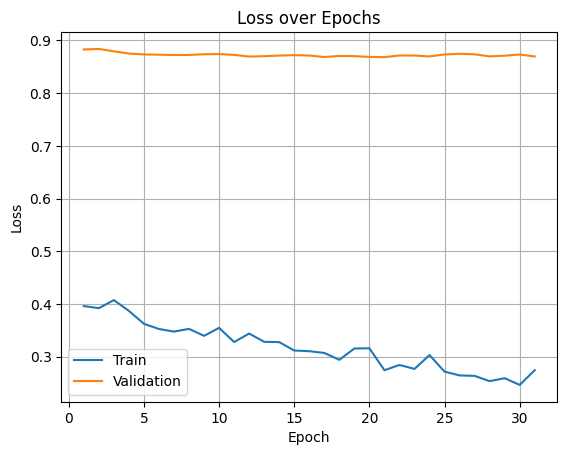

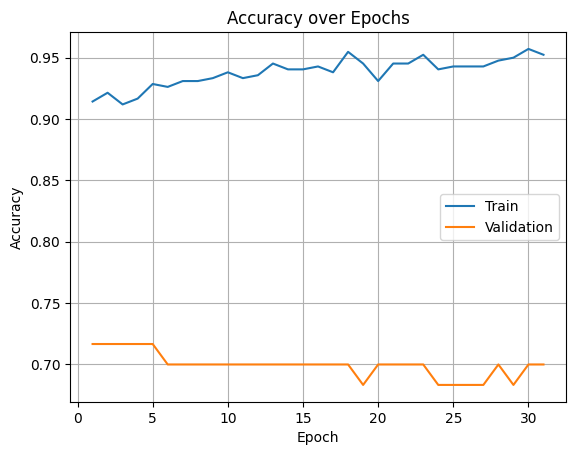

In [18]:
history = train_bert_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=EPOCHS,
    optimizer=optimizer,
    loss_function=loss_function,
    patience=10,
    checkpoint_dir="./checkpoints_100per",
    resume=True
)
plot_history(history)

In [19]:
checkpoint = torch.load("./checkpoints_100per/best_model.pt", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

test_loss, test_accuracy, precision, recall, f1, preds, targets = evaluate_bert_model(
    model=model,
    data_loader=test_loader,
    loss_function=loss_function,
    device=device,
    set_name="Test"
)

print(f"Final Test Accuracy: {test_accuracy * 100:.2f}% | Test Loss: {test_loss:.4f}")

Test Evaluation: 100%|██████████| 4/4 [00:01<00:00,  2.50it/s, loss=0.783]

Test Loss: 0.8558 | Acc: 73.33% | P: 0.7365 | R: 0.7333 | F1: 0.7321
Final Test Accuracy: 73.33% | Test Loss: 0.8558


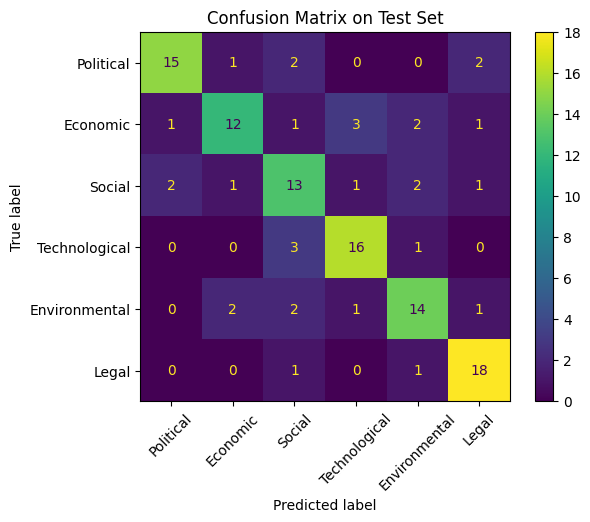

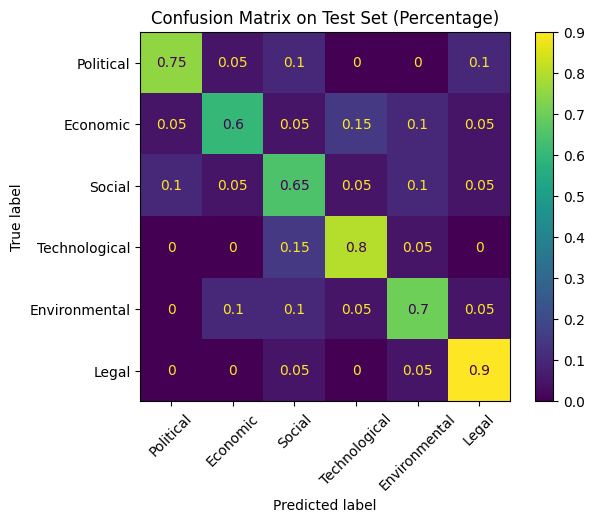

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(targets, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.show()

cm = confusion_matrix(targets, preds)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
cm_display = np.round(cm_percent, 5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_display, display_labels=class_names)
disp.plot(cmap='viridis', xticks_rotation=45)
plt.title("Confusion Matrix on Test Set (Percentage)")
plt.show()